# Combining sleep and circadian models

In [ ]:
#| hide 
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import circmean
from circadian.models import Skeldon23
from circadian.lights import LightSchedule

Circadian rhythms govern our daily patterns of rest and wakefulness and determine when we fall asleep and wake up. However, models such as `Forger99` or `Hannay19` don't predict sleep timing or duration. A family of models known as two-process models address this by coupling circadian rhythms with sleep pressure modeling. Here, we explore the two-process model in [Skeldon et al. 2023](https://doi.org/10.1101/2023.06.14.544757) which combines `Forger99`'s circadian rhythm with a sleep homeostat that accumulates sleep pressure during wakefulness and dissipates during sleep. The model receives a light schedule as an input and is able to produce realistic sleep timings and durations. It is implemented in `circadian.models` as `Skeldon23`.  

# Regular schedule

In order to obtain a prediction for sleep/wake onset, we need to provide the model with a light schedule. Following the original article, we'll use a smooth light function defined in the following way:

In [ ]:
def smooth_light(t):
    rise = np.tanh(0.6 * (t - 8.0))
    fall = np.tanh(0.6 * (t - 17.0))
    y = (700.0 / 2.0) * (rise - fall) + 40.0
    return y

Then, we can define the schedule, equilibrate the model, and simulate:

In [ ]:
schedule = LightSchedule(smooth_light, period=24.0)
dt = 0.01 # hours
days = 5
time = np.arange(8.0, 24 * days + 8.0, dt)
light = schedule(time)
model = Skeldon23()
# equilibrate model
initial_condition = model.equilibrate(time, light, num_loops=20)
# simulate model
trajectory = model(time, initial_condition=initial_condition, input=light)
sleep = model.sleep_state
received_light = model.received_light

Note that the model output constists of:

- A `trajectory` containing the information of the model's four state variables ($x$, $x_c$, $n$, and $H$) over time. Here we have favored `Forger99`'s notation of variables whereas the original article uses $x$, $y$, $n$, and $H$ respectively.

- A `sleep` array containing the sleep state for each timepoint. This is a binary array with 1 indicating sleep and 0 indicating wake.

- A `received_light` array encoding the light input to the circadian model for each timepoint. This light input is different from the provided `light` array only in those timepoints where the sleep state is 1 (i.e. asleep).

We can then visualize the predicted sleep windows

In [ ]:
#| hide
sleep_start = np.where(np.diff(sleep) == 1)[0][0]
sleep_end = np.where(np.diff(sleep) == -1)[0][-1]

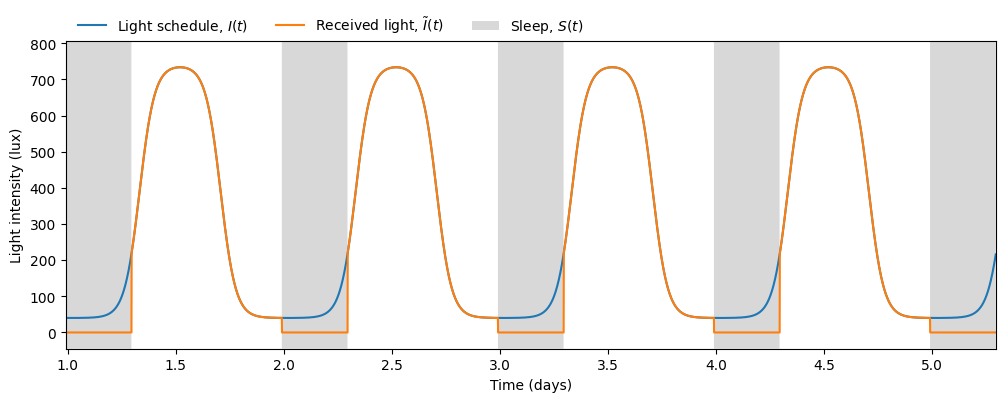

In [ ]:
#| echo: false
fig = plt.figure(figsize=(12, 4))
ax = plt.gca()

plt.plot(time / 24.0, light, label=r'Light schedule, $I(t)$')
plt.plot(time / 24.0, received_light, label=r'Received light, $\tilde{I}(t)$')
min_state = 1.5 * (min(received_light) - 30)
max_state = 1.1 * max(received_light)
ax.fill_between(time / 24.0, min_state, max_state, where=(sleep == 1), color='gray', alpha=0.3, edgecolor='None', label=r'Sleep, $S(t)$')
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.125), frameon=False, ncols=3)
ax.set_xlim(time[sleep_start] / 24.0, time[sleep_end] / 24.0)
ax.set_ylim(min_state, max_state)
ax.set_xlabel('Time (days)')
ax.set_ylabel('Light intensity (lux)')
plt.show()

and the circadian state from the $x$ variable

In [ ]:
#| hide
circadian_state = trajectory.states[:, 0]

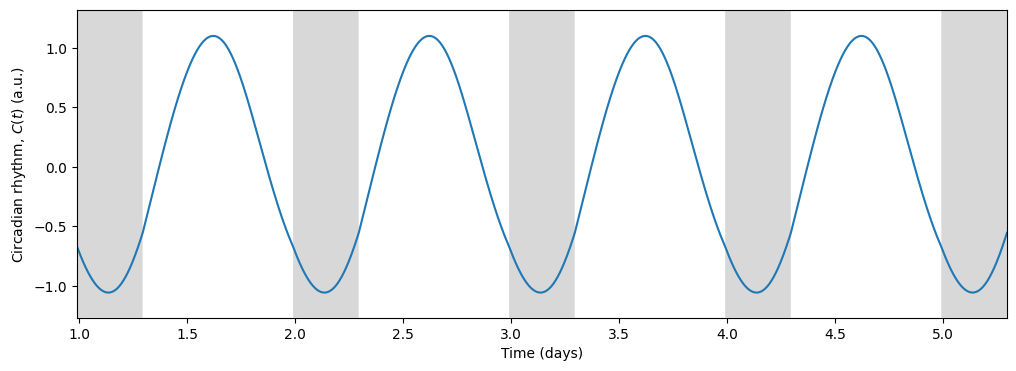

In [ ]:
#| echo: false
fig = plt.figure(figsize=(12, 4))
ax = plt.gca()
plt.plot(time / 24.0, circadian_state)
min_state = 1.2 * min(circadian_state)
max_state = 1.2 * max(circadian_state)
ax.fill_between(time / 24.0, min_state, max_state, where=(sleep == 1), color='gray', alpha=0.3, edgecolor='None', label='Sleep')
ax.set_xlim(time[sleep_start] / 24.0, time[sleep_end] / 24.0)
ax.set_ylim(min_state, max_state)
ax.set_xlabel('Time (days)')
ax.set_ylabel(r'Circadian rhythm, $C(t)$ (a.u.)')
plt.show()

Light, being the primary input to the circadian model, drives the circadian state through the forcing term $B(t)$:

In [ ]:
#| hide
def forcing_B(model, trajectory, light):
    x = trajectory.states[:, 0]
    xc = trajectory.states[:, 1]
    n = trajectory.states[:, 2]

    alpha = model.alpha_0 * pow((light / model.I0), model.p)
    B = model.G * (1.0 - n) * alpha * (1.0 - model.b * x) * (1.0 - model.b * xc)

    return B

In [ ]:
#| hide
B_values = forcing_B(model, trajectory, received_light)

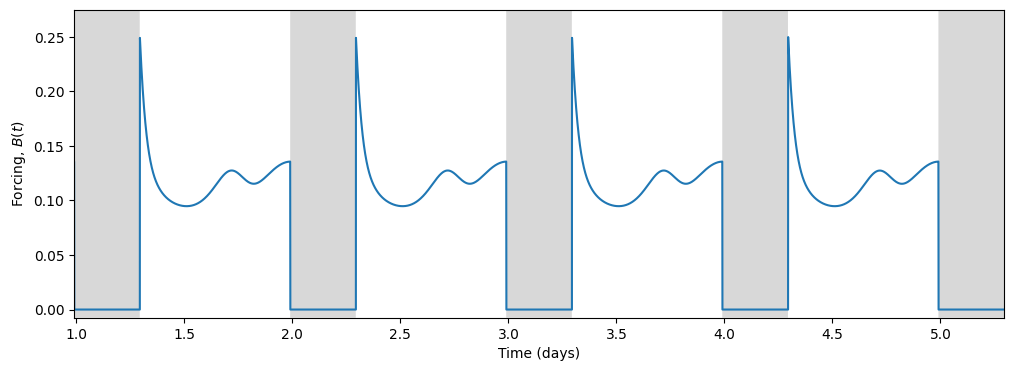

In [ ]:
#| echo: false
fig = plt.figure(figsize=(12, 4))
ax = plt.gca()
ax.plot(time / 24.0, B_values)
ax.set_ylabel(r'Forcing, $B(t)$')
ax.set_xlabel('Time (days)')
min_state = 1.5 * (min(B_values) - 5e-3)
max_state = 1.1 * max(B_values)
ax.fill_between(time / 24.0, min_state, max_state, where=(sleep == 1), color='gray', alpha=0.3, edgecolor='None', label='Sleep')
ax.set_xlim(time[sleep_start] / 24.0, time[sleep_end] / 24.0)
ax.set_ylim(min_state, max_state)
plt.show()

In turn, the circadian state modulates sleep. Skeldon et al. define a function $C(t)$ that determines the propensity of an individual to go to sleep or wake up. 

In [ ]:
#| hide
def circadian_modulation_of_sleep(model, trajectory):
    # calculate the new sleep state
    x = trajectory.states[:, 0]
    xc = trajectory.states[:, 1]
    linear_term = model.c20 + model.alpha21 * xc + model.alpha22 * x
    quadratic_term = model.beta21 * xc * xc + model.beta22 * xc * x + model.beta23 * x * x
    C = linear_term + quadratic_term
    return C

In [ ]:
#| hide
circadian_wake_propensity = circadian_modulation_of_sleep(model, trajectory)

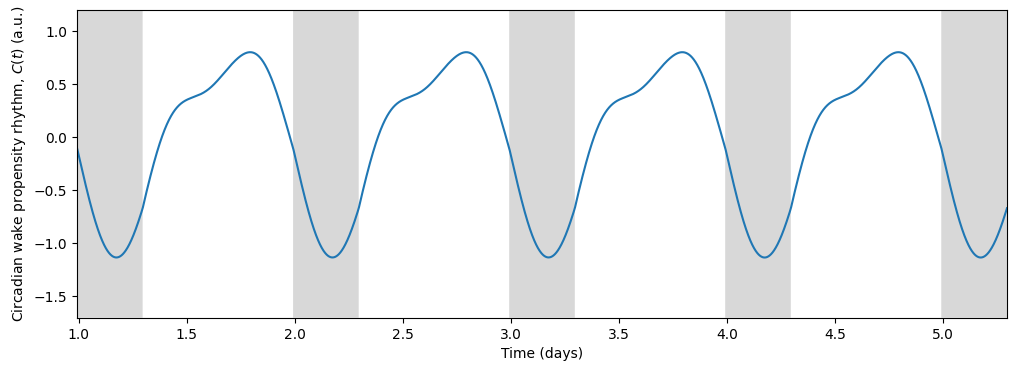

In [ ]:
#| echo: false
fig = plt.figure(figsize=(12, 4))
ax = plt.gca()
ax.plot(time / 24.0, circadian_wake_propensity)
ax.set_ylabel(r"Circadian wake propensity rhythm, $C(t)$ (a.u.)")
ax.set_xlabel('Time (days)')
min_state = 1.5 * min(circadian_wake_propensity)
max_state = 1.5 * max(circadian_wake_propensity)
ax.fill_between(time / 24.0, min_state, max_state, where=(sleep == 1), color='gray', alpha=0.3, edgecolor='None', label='Sleep')
ax.set_xlim(time[sleep_start] / 24.0, time[sleep_end] / 24.0)
ax.set_ylim(min_state, max_state)
plt.show()

$C(t)$ determines when the sleep pressure $H(t)$ has accumulated sufficiently to trigger sleep (at threshold $H^+$) and when it has dissipated sufficiently to allow wake (at threshold $H^-$).

In [ ]:
#| hide
def H_thresholds(model, trajectory):
    C = circadian_modulation_of_sleep(model, trajectory)
    H_plus = model.H0 + 0.5 * model.Delta + model.ca * C
    H_minus = model.H0 - 0.5 * model.Delta + model.ca * C 
    return H_plus, H_minus

In [ ]:
#| hide
sleep_pressure = trajectory.states[:, 3]
H_plus, H_minus = H_thresholds(model, trajectory)

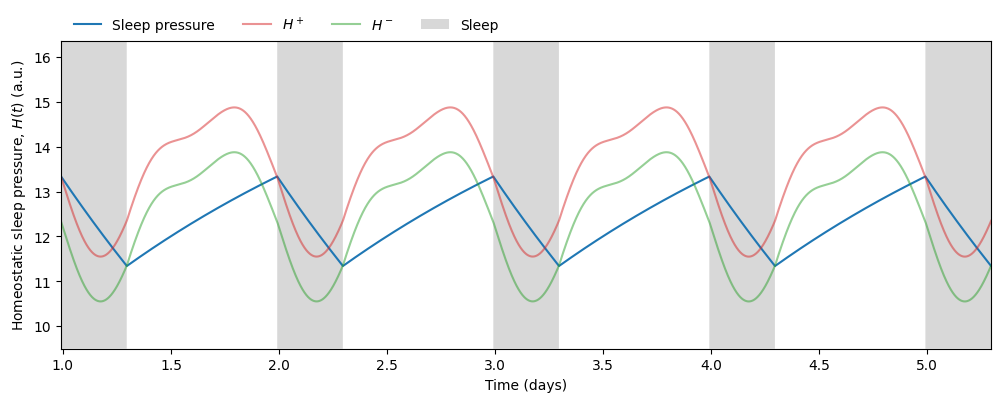

In [ ]:
#| echo: false
fig = plt.figure(figsize=(12, 4))
ax = plt.gca()
ax.plot(time / 24.0, sleep_pressure, label='Sleep pressure')
ax.plot(time / 24.0, H_plus, color='tab:red', alpha=0.5, label=r'$H^+$')
ax.plot(time / 24.0, H_minus, color='tab:green', alpha=0.5, label=r'$H^-$')
ax.set_ylabel(r'Homeostatic sleep pressure, $H(t)$ (a.u.)')
ax.set_xlabel('Time (days)')
min_state = 0.9 * min(H_minus)
max_state = 1.1 * max(H_plus)
ax.fill_between(time / 24.0, min_state, max_state, where=(sleep == 1), color='gray', alpha=0.3, edgecolor='None', label='Sleep')
ax.set_xlim(time[sleep_start] / 24.0, time[sleep_end] / 24.0)
ax.set_ylim(min_state, max_state)
ax.legend(loc='upper left', bbox_to_anchor=(0.0, 1.125), ncol=4, frameon=False)
plt.show()

Therefore, given any light schedule and initial conditions we can predict not only the phase of the circadian rhythm but also the timing and duration of sleep. In this simulation we obtain an average sleep timing and duration of

In [ ]:
# sleep start
sleep_start_idxs = np.where(np.diff(sleep) == 1)[0]
sleep_start_times = np.mod(time[sleep_start_idxs], 24.0)
avg_sleep_start = circmean(sleep_start_times, high=24.0)
# sleep end
sleep_end_idxs = np.where(np.diff(sleep) == -1)[0]
sleep_end_times = np.mod(time[sleep_end_idxs], 24.0)
avg_sleep_end = circmean(sleep_end_times, high=24.0)
# sleep duration
sleep_end_idxs = np.where(np.diff(sleep) == -1)[0]
sleep_duration = time[sleep_end_idxs] - time[sleep_start_idxs]
print(f'Average sleep start: {avg_sleep_start:.2f} h, Average sleep end: {avg_sleep_end:.2f} h, Average sleep duration: {np.mean(sleep_duration):.2f} h') #| hide_line

Average sleep start: 23.79 h, Average sleep end: 7.09 h, Average sleep duration: 7.30 h


# Shift work schedule

The model allows us to explore how much sleep would a shift worker get in a typical light schedule. Applying the same pipeline as above but using `LightSchedule.ShiftWork` we obtain the following results:

```python
schedule = LightSchedule.ShiftWork()
dt = 0.01 # hours
days = 7
time = np.arange(0, 24 * days, dt)
light = schedule(time)
model = Skeldon23()
# equilibrate model
initial_condition = model.equilibrate(time, light)
# simulate model
trajectory = model(time, initial_condition=initial_condition, input=light)
sleep = model.sleep_state
received_light = model.received_light
```

In [ ]:
#| hide
schedule = LightSchedule.ShiftWork()
dt = 0.01 # hours
days = 7
time = np.arange(0, 24 * days, dt)
light = schedule(time)
model = Skeldon23()
# equilibrate model
initial_condition = model.equilibrate(time, light)
# simulate model
trajectory = model(time, initial_condition=initial_condition, input=light)
sleep = model.sleep_state
received_light = model.received_light

c:\users\tavel\desktop\internship-arcascope\circadian\circadian\models.py:427: UserWarning: The model did not equilibrate. Try increasing the number of loops.
  warnings.warn("The model did not equilibrate. Try increasing the number of loops.")


In [ ]:
#| hide
sleep_start = np.where(np.diff(sleep) == 1)[0][0]
sleep_end = np.where(np.diff(sleep) == -1)[0][-1]

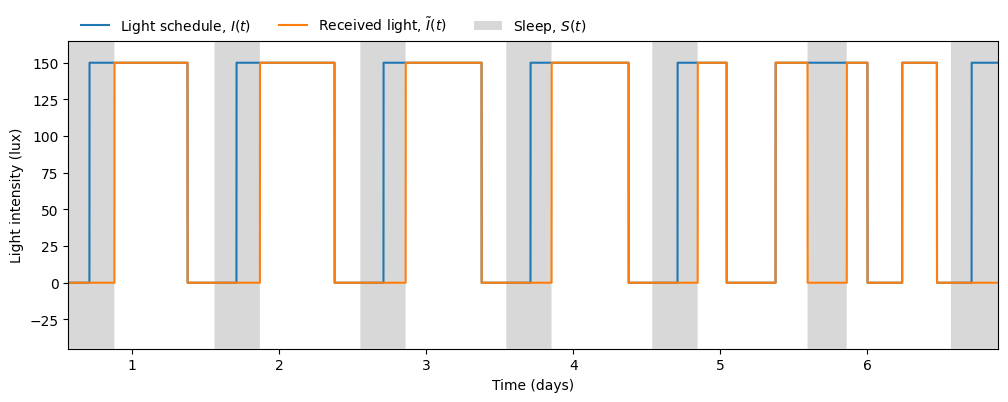

In [ ]:
#| echo: false
fig = plt.figure(figsize=(12, 4))
ax = plt.gca()

plt.plot(time / 24.0, light, label=r'Light schedule, $I(t)$')
plt.plot(time / 24.0, received_light, label=r'Received light, $\tilde{I}(t)$')
min_state = 1.5 * (min(received_light) - 30)
max_state = 1.1 * max(received_light)
ax.fill_between(time / 24.0, min_state, max_state, where=(sleep == 1), color='gray', alpha=0.3, edgecolor='None', label=r'Sleep, $S(t)$')
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.125), frameon=False, ncols=3)
ax.set_xlim(time[sleep_start] / 24.0, time[sleep_end] / 24.0)
ax.set_ylim(min_state, max_state)
ax.set_xlabel('Time (days)')
ax.set_ylabel('Light intensity (lux)')
plt.show()

In [ ]:
#| hide
circadian_state = trajectory.states[:, 0]

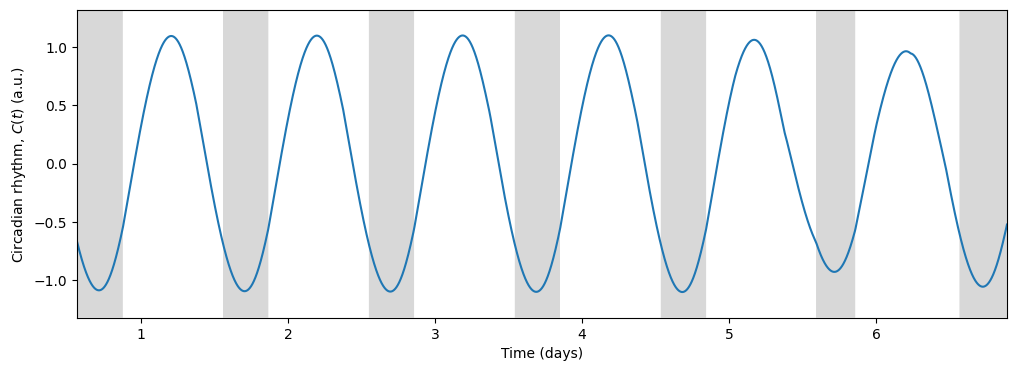

In [ ]:
#| echo: false
fig = plt.figure(figsize=(12, 4))
ax = plt.gca()
plt.plot(time / 24.0, circadian_state)
min_state = 1.2 * min(circadian_state)
max_state = 1.2 * max(circadian_state)
ax.fill_between(time / 24.0, min_state, max_state, where=(sleep == 1), color='gray', alpha=0.3, edgecolor='None', label='Sleep')
ax.set_xlim(time[sleep_start] / 24.0, time[sleep_end] / 24.0)
ax.set_ylim(min_state, max_state)
ax.set_xlabel('Time (days)')
ax.set_ylabel(r'Circadian rhythm, $C(t)$ (a.u.)')
plt.show()

In [ ]:
#| hide
B_values = forcing_B(model, trajectory, received_light)

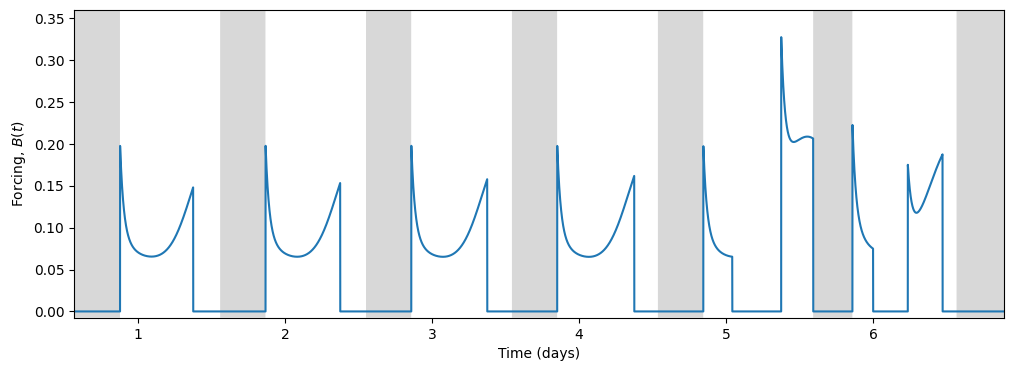

In [ ]:
#| echo: false
fig = plt.figure(figsize=(12, 4))
ax = plt.gca()
ax.plot(time / 24.0, B_values)
ax.set_ylabel(r'Forcing, $B(t)$')
ax.set_xlabel('Time (days)')
min_state = 1.5 * (min(B_values) - 5e-3)
max_state = 1.1 * max(B_values)
ax.fill_between(time / 24.0, min_state, max_state, where=(sleep == 1), color='gray', alpha=0.3, edgecolor='None', label='Sleep')
ax.set_xlim(time[sleep_start] / 24.0, time[sleep_end] / 24.0)
ax.set_ylim(min_state, max_state)
plt.show()

In [ ]:
#| hide
circadian_wake_propensity = circadian_modulation_of_sleep(model, trajectory)

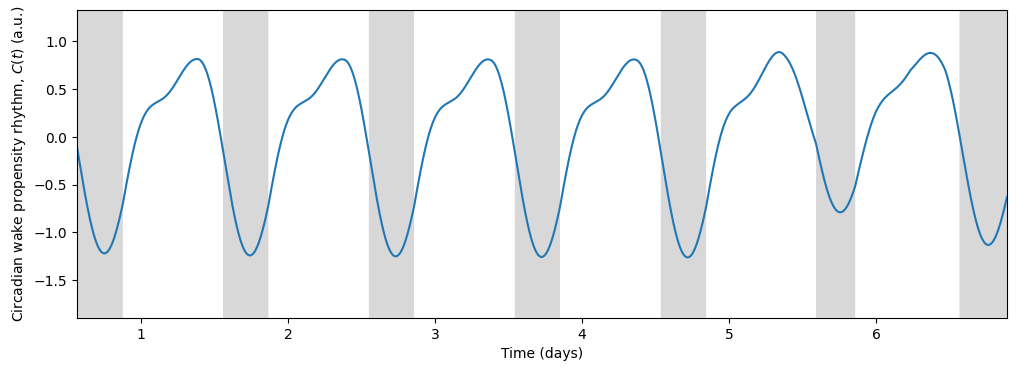

In [ ]:
#| echo: false
fig = plt.figure(figsize=(12, 4))
ax = plt.gca()
ax.plot(time / 24.0, circadian_wake_propensity)
ax.set_ylabel(r"Circadian wake propensity rhythm, $C(t)$ (a.u.)")
ax.set_xlabel('Time (days)')
min_state = 1.5 * min(circadian_wake_propensity)
max_state = 1.5 * max(circadian_wake_propensity)
ax.fill_between(time / 24.0, min_state, max_state, where=(sleep == 1), color='gray', alpha=0.3, edgecolor='None', label='Sleep')
ax.set_xlim(time[sleep_start] / 24.0, time[sleep_end] / 24.0)
ax.set_ylim(min_state, max_state)
plt.show()

In [ ]:
#| hide
sleep_pressure = trajectory.states[:, 3]
H_plus, H_minus = H_thresholds(model, trajectory)

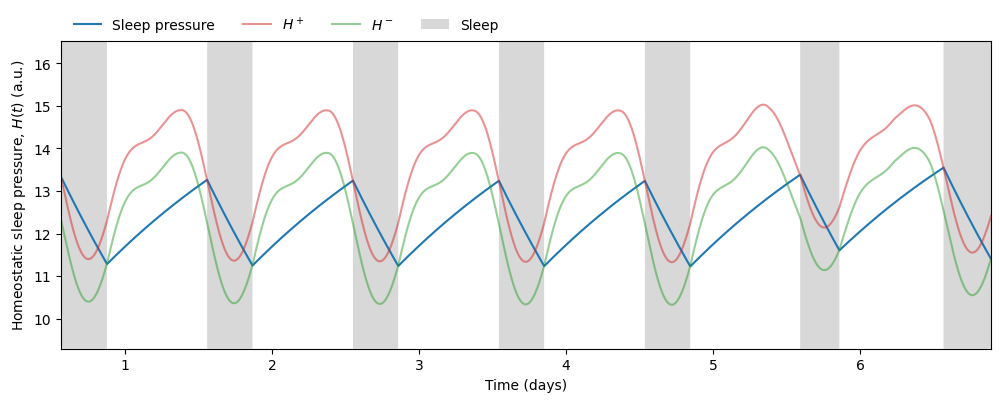

In [ ]:
#| echo: false
fig = plt.figure(figsize=(12, 4))
ax = plt.gca()
ax.plot(time / 24.0, sleep_pressure, label='Sleep pressure')
ax.plot(time / 24.0, H_plus, color='tab:red', alpha=0.5, label=r'$H^+$')
ax.plot(time / 24.0, H_minus, color='tab:green', alpha=0.5, label=r'$H^-$')
ax.set_ylabel(r'Homeostatic sleep pressure, $H(t)$ (a.u.)')
ax.set_xlabel('Time (days)')
min_state = 0.9 * min(H_minus)
max_state = 1.1 * max(H_plus)
ax.fill_between(time / 24.0, min_state, max_state, where=(sleep == 1), color='gray', alpha=0.3, edgecolor='None', label='Sleep')
ax.set_xlim(time[sleep_start] / 24.0, time[sleep_end] / 24.0)
ax.set_ylim(min_state, max_state)
ax.legend(loc='upper left', bbox_to_anchor=(0.0, 1.125), ncol=4, frameon=False)
plt.show()

In [ ]:
# sleep start
sleep_start_idxs = np.where(np.diff(sleep) == 1)[0]
sleep_start_times = np.mod(time[sleep_start_idxs], 24.0)
avg_sleep_start = circmean(sleep_start_times, high=24.0)
# sleep end
sleep_end_idxs = np.where(np.diff(sleep) == -1)[0]
sleep_end_times = np.mod(time[sleep_end_idxs], 24.0)
avg_sleep_end = circmean(sleep_end_times, high=24.0)
# sleep duration
sleep_end_idxs = np.where(np.diff(sleep) == -1)[0]
sleep_duration = time[sleep_end_idxs] - time[sleep_start_idxs]
print(f'Average sleep start: {avg_sleep_start:.2f} h, Average sleep end: {avg_sleep_end:.2f} h, Average sleep duration: {np.mean(sleep_duration):.2f} h') #| hide_line

Average sleep start: 13.41 h, Average sleep end: 20.73 h, Average sleep duration: 7.32 h


Even though the sleep duration is not so different from the regular schedule, the sleep timing clashes with the shift in light exposure during days off (days 5 and 6). The model keeps the rhythm of previous shift work days, making it hard to switch to a regular schedule on days off.

# Predicted sleep as a function of circadian period $\tau_c$

In the original article, Skeldon et al. explore how different parameters affect sleep duration, mid-sleep timing, and circadian state minimum. Using `circadian` we can do a similar exploration, analyzing how the intrinsic period $\tau_c$ modulates these quantities under two different light schedules, one with low baseline intensity (10 lux) and one with high baseline intensity (100 lux).

In [ ]:
def low_baseline_schedule(t):
    rise = np.tanh(t - 7.0)
    fall = np.tanh(t - 18.0)
    y = ((10000.0 - 10.0) / 2.0) * (rise - fall) + 10.0
    return y

def high_baseline_schedule(t):
    rise = np.tanh(t - 7.0)
    fall = np.tanh(t - 18.0)
    y = ((10000.0 - 100.0) / 2.0) * (rise - fall) + 100.0
    return y

light_schedules = {
    'low_baseline': LightSchedule(low_baseline_schedule, period=24),
    'high_baseline': LightSchedule(high_baseline_schedule, period=24)
}

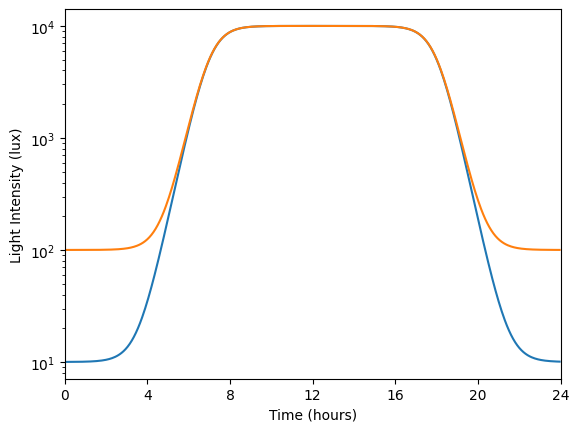

In [ ]:
#| echo: false
# plot light schedules
dt = 0.05 # hours
time = np.arange(0, 24, dt)
plt.plot(time, light_schedules['low_baseline'](time), label='Low baseline (10 lux)')
plt.plot(time, light_schedules['high_baseline'](time), label='High baseline (100 lux)')
plt.xlim(0, 24)
plt.xticks(np.arange(0, 25, 4))
plt.xlabel('Time (hours)')
plt.ylabel('Light Intensity (lux)')
plt.yscale('log')
plt.legend()
plt.show()

For each value of intrinsic period we equilibrate the system for 60 days and then store 5 days of simulated data:

In [ ]:
#| output: false
results = {
    'low_baseline': {
        'trajectories': [],
        'sleep': [],
        'sleep_duration': [],
        'mid_sleep_time': [],
        'circadian_minimum_time': []
    },
    'high_baseline': {
        'trajectories': [],
        'sleep': [],
        'sleep_duration': [],
        'mid_sleep_time': [],
        'circadian_minimum_time': []
    }
}

dt = 0.05 # hours
days = 5
time = np.arange(0, 24 * days, dt)
intrinsic_periods = np.linspace(23.6, 24.25, 20)

for schedule_name in light_schedules:
    schedule = light_schedules[schedule_name]
    light = schedule(time)
    for tauc in intrinsic_periods:
        model = Skeldon23(params={'tauc': tauc})
        # equilibrate model
        initial_condition = model.equilibrate(time, light, num_loops=12)
        # simulate model
        trajectory = model(time, initial_condition, light)
        # calculate sleep metrics
        sleep = model.sleep_state
        mid_sleep_time, sleep_duration = sleep_midpoint_and_duration(time, sleep)
        circadian_minimum = np.mean(np.mod(model.cbt(), 24))
        # store results
        results[schedule_name]['trajectories'].append(trajectory)
        results[schedule_name]['sleep'].append(sleep)
        results[schedule_name]['sleep_duration'].append(sleep_duration)
        results[schedule_name]['mid_sleep_time'].append(mid_sleep_time)
        results[schedule_name]['circadian_minimum_time'].append(circadian_minimum)

c:\users\tavel\desktop\internship-arcascope\circadian\circadian\models.py:419: UserWarning: The model did not equilibrate. Try increasing the number of loops.
  warnings.warn("The model did not equilibrate. Try increasing the number of loops.")


We can visualize the effect of the intrinsic period on the predicted sleep windows

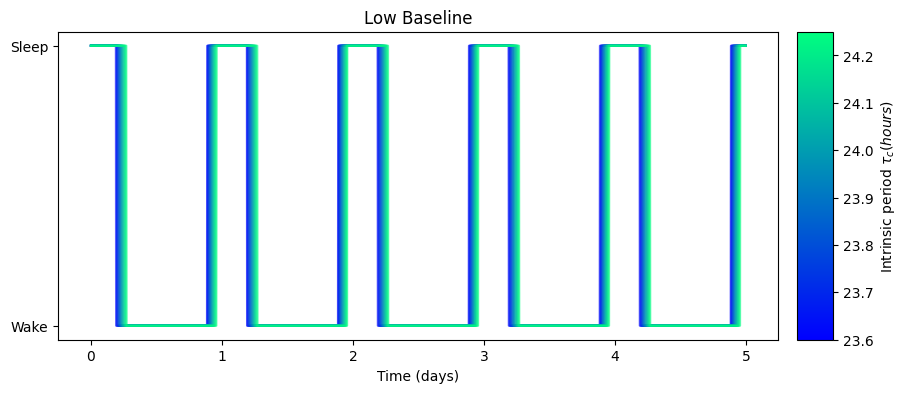

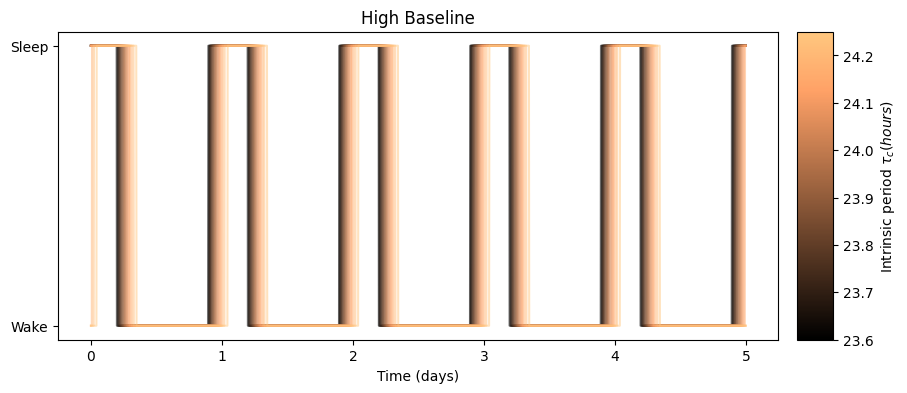

In [ ]:
#| echo: false
# low baseline
fig_low, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [20, 1]}, figsize=(10, 4))
ax.set_title('Low Baseline')
fig_low.subplots_adjust(wspace=0.05)
cmap = mpl.colormaps['winter']

for i in range(len(intrinsic_periods)):
    sleep = results['low_baseline']['sleep'][i]
    ax.plot(time / 24.0, sleep, color=cmap(i / (len(intrinsic_periods) - 1.0)), alpha=0.5)

norm = mpl.colors.Normalize( vmin=min(intrinsic_periods), vmax=max(intrinsic_periods))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label(r'Intrinsic period $\tau_{c} (hours)$')
ax.set_xlabel('Time (days)')
ax.set_yticks([0, 1])
ax.set_yticklabels(['Wake', 'Sleep'])

# high baseline
fig_high, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [20, 1]}, figsize=(10, 4))
ax.set_title('High Baseline')
fig_high.subplots_adjust(wspace=0.05)
cmap = mpl.colormaps['copper']

for i in range(len(intrinsic_periods)):
    sleep = results['high_baseline']['sleep'][i]
    ax.plot(time / 24.0, sleep, color=cmap(i / (len(intrinsic_periods) - 1.0)), alpha=0.5)

norm = mpl.colors.Normalize( vmin=min(intrinsic_periods), vmax=max(intrinsic_periods))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label(r'Intrinsic period $\tau_{c} (hours)$')
ax.set_xlabel('Time (days)')
ax.set_yticks([0, 1])
ax.set_yticklabels(['Wake', 'Sleep'])

plt.show()


as well as its effect on the circadian rhythm:

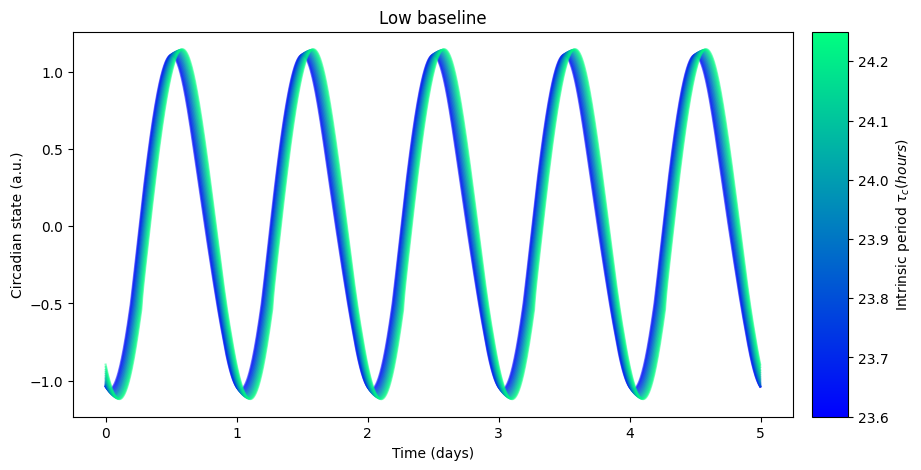

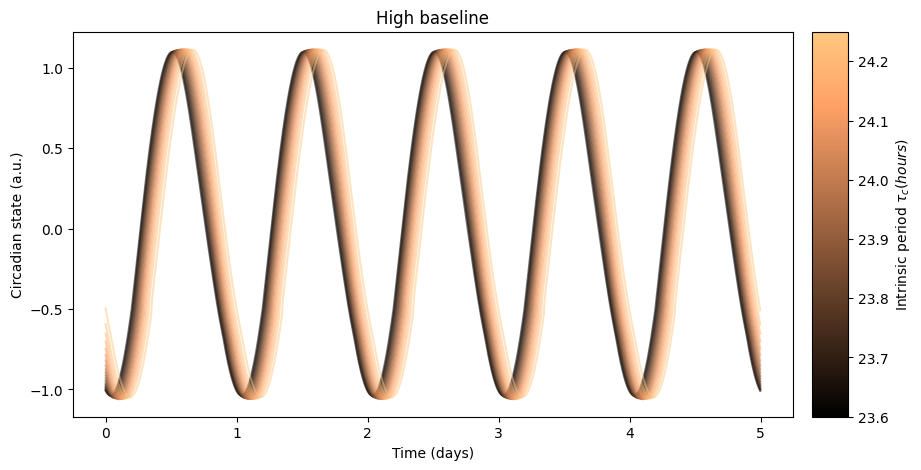

In [ ]:
#| echo: false
fig_low, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [20, 1]}, figsize=(10, 5))
fig_low.subplots_adjust(wspace=0.05)
ax.set_title('Low baseline')
cmap = mpl.colormaps['winter']

for i in range(len(intrinsic_periods)):
    x = results['low_baseline']['trajectories'][i].states[:, 0]
    ax.plot(time / 24.0, x, color=cmap(i / (len(intrinsic_periods) - 1.0)), alpha=0.5)

norm = mpl.colors.Normalize( vmin=min(intrinsic_periods), vmax=max(intrinsic_periods))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label(r'Intrinsic period $\tau_{c} (hours)$')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Circadian state (a.u.)')

# high baseline
fig_high, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [20, 1]}, figsize=(10, 5))
fig_high.subplots_adjust(wspace=0.05)
ax.set_title('High baseline')
cmap = mpl.colormaps['copper']

for i in range(len(intrinsic_periods)):
    x = results['high_baseline']['trajectories'][i].states[:, 0]
    ax.plot(time / 24.0, x, color=cmap(i / (len(intrinsic_periods) - 1.0)), alpha=0.5)

norm = mpl.colors.Normalize( vmin=min(intrinsic_periods), vmax=max(intrinsic_periods))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label(r'Intrinsic period $\tau_{c} (hours)$')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Circadian state (a.u.)')

plt.show()

The high baseline simulations seem to affect both sleep and circadian state the most. 

The high baseline schedule seems to have a greater effect on sleep and circadian state than the low baseline schedule. On our main simulation loop, we used the function `sleep_midpoint_and_duration` from the module `circadian.utils` to quantify these effects. Their plots are shown below and confirm this observation in agreement with the results from Skeldon et al. 2023:

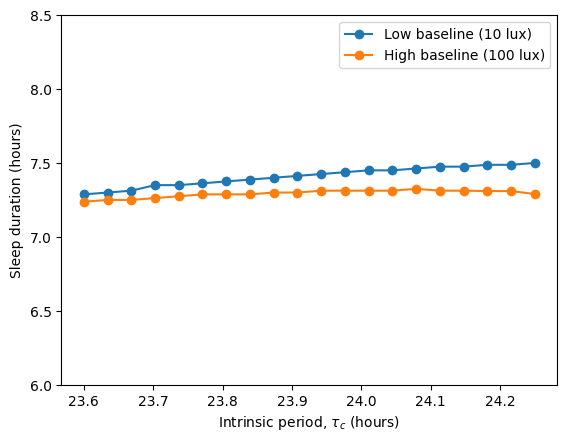

In [ ]:
#| echo: false
sleep_duration_low = results['low_baseline']['sleep_duration']
sleep_duration_high = results['high_baseline']['sleep_duration']
plt.plot(intrinsic_periods, sleep_duration_low, '-o', label='Low baseline (10 lux)')
plt.plot(intrinsic_periods, sleep_duration_high, '-o', label='High baseline (100 lux)')
plt.xlabel(r'Intrinsic period, $\tau_c$ (hours)')
plt.ylabel('Sleep duration (hours)')
plt.ylim(6, 8.5)
plt.legend()
plt.show()

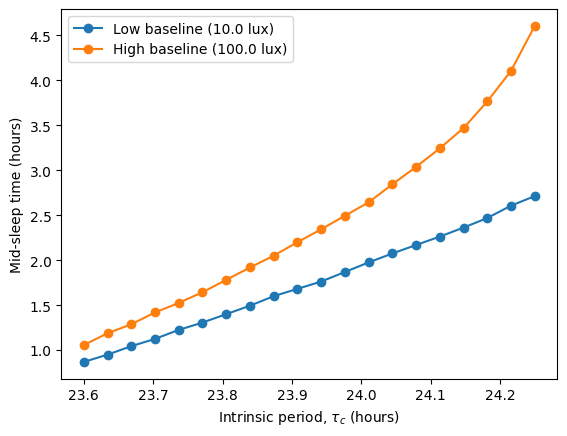

In [ ]:
#| echo: false
mid_sleep_low = results['low_baseline']['mid_sleep_time']
mid_sleep_high = results['high_baseline']['mid_sleep_time']
plt.plot(intrinsic_periods, mid_sleep_low, '-o', label='Low baseline (10.0 lux)')
plt.plot(intrinsic_periods, mid_sleep_high, '-o', label='High baseline (100.0 lux)')
plt.xlabel(r'Intrinsic period, $\tau_c$ (hours)')
plt.ylabel('Mid-sleep time (hours)')
plt.legend()
plt.show()

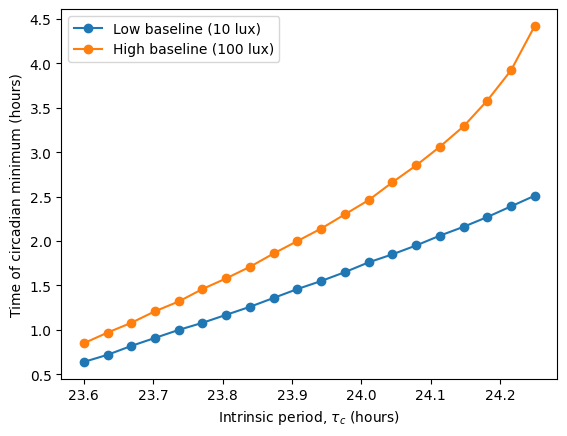

In [ ]:
#| echo: false
minimum_low = results['low_baseline']['circadian_minimum_time']
minimum_high = results['high_baseline']['circadian_minimum_time']
plt.plot(intrinsic_periods, minimum_low, '-o', label='Low baseline (10 lux)')
plt.plot(intrinsic_periods, minimum_high, '-o', label='High baseline (100 lux)')
plt.xlabel(r'Intrinsic period, $\tau_c$ (hours)')
plt.ylabel('Time of circadian minimum (hours)')
plt.legend()
plt.legend()
plt.show()